In [2]:

import os
import csv
import argparse
import numpy as np 
import scipy.misc
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

file = 'data/fer2013/fer2013.csv'
output = 'data/fer2013/extracted'

w, h = 48, 48
image = np.zeros((h, w), dtype=np.uint8)
id = 1
from PIL import Image
from matplotlib.pyplot import imshow
# with open(file, 'r') as csvfile:
#     datareader = csv.reader(csvfile, delimiter =',')
# #     print headers 
#     for i,row in enumerate(datareader):  
#         if i==0:
#             continue
#         emotion = row[0]
#         pixels = list(map(int, row[1].split()))
# #         print(row)
#         usage = row[2]
#         #print emotion, type(pixels[0]), usage
#         pixels_array = np.asarray(pixels)

#         image = pixels_array.reshape(w, h)
#         #print image.shape

#         stacked_image = np.dstack((image,) * 3)
#         #print stacked_image.shape


#         image_folder = os.path.join(output, usage)
#         if not os.path.exists(image_folder):
#             os.makedirs(image_folder)
#         image_file =  os.path.join(image_folder , str(id) + '.jpg')
#         scipy.misc.imsave(image_file, stacked_image)
#         id += 1 
#         if id % 100 == 0:
#             print('Processed {} images'.format(id))

# print("Finished processing {} images".format(id))

In [3]:
import pandas as pd 
dataset = pd.read_csv(file)

In [4]:
# for i, dirname in enumerate(dirnames):
#     filenames =[ os.path.join(dirname,filename) for filename in os.listdir(dirname)]
#     img=mpimg.imread(np.random.choice(filenames))
#     plt.subplot(len(dirnames) / columns + 1, columns, i + 1)
#     plt.imshow(img)
# plt.show()

### 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral


In [5]:
dataset.iloc[:10,:]

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [6]:
dataset.Usage.unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [7]:

training = dataset[dataset['Usage']=='Training']
validation = dataset[dataset['Usage']=='PublicTest']
test = dataset[dataset['Usage']=='PrivateTest']
training.shape
validation.shape
test.shape

(28709, 3)

(3589, 3)

(3589, 3)

In [8]:
train_val_common = set(training.pixels) & set(validation.pixels)
train_test_common = set(training.pixels) & set(test.pixels)
len(train_val_common)
len(train_test_common)

270

278

In [9]:
validation = validation[~validation['pixels'].isin(train_val_common)]
test = test[~test['pixels'].isin(train_test_common)]

In [10]:
def pixstr2numpy(pixstr):
    pixels = np.array(pixstr.split())
    pixels = pixels.reshape(w, h)
    return pixels.astype(np.int32)

def to3D(array):
    size = array.shape[0]
    X_t = np.zeros((size,48,48))
    for i,x in enumerate(array):
        X_t[i,:,:] = x
    X_t = X_t.astype(np.int32)
    return X_t

def X_Y_split(df):
    X_train,Y_train = df['pixels'].apply(pixstr2numpy),df['emotion'].astype(np.int32)
    X_train = np.array(X_train)
    X_train = to3D(X_train)
    Y_train  = Y_train.values
    return X_train,Y_train

In [11]:
#X_train,Y_train = training['pixels'].apply(pixstr2numpy),training['emotion'].astype(np.int32)

In [12]:
X_train,Y_train = X_Y_split(training)

In [32]:
X_validation,Y_validation = X_Y_split(validation)
X_test,Y_test = X_Y_split(test)

In [33]:
X_train = np.array([X_train, X_train, X_train])
X_train =X_train.swapaxes(0, 1)
X_validation = np.array([X_validation, X_validation, X_validation])
X_validation = X_validation.swapaxes(0,1)
X_test = np.array([X_test, X_test, X_test])
X_test = X_test.swapaxes(0,1)
X_train.shape

(28709, 3, 48, 48, 3)

In [34]:
X_train = X_train.swapaxes(1,3)
X_validation = X_validation.swapaxes(1,3)
X_test = X_test.swapaxes(1,3)
X_train = X_train.swapaxes(1,2)
X_validation = X_validation.swapaxes(1,2)
X_test = X_test.swapaxes(1,2)

In [17]:
def dis(array):
    im = Image.fromarray(array,mode='I') 
    imshow(im)

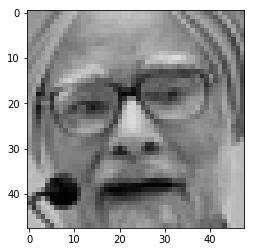

In [18]:
X_train = X_train.swapaxes(1,2)
dis(X_train[1,:,:,2])

In [19]:
def to_one_hot(data):
    mask = np.array(range(7)).reshape(1,-1)
    data = data.reshape(-1,1)
    res = data == mask
    return res.astype(np.int32)

In [48]:
Y_validation_.shape


(3309, 7)

In [50]:
Y_train.shape

(200963, 7)

In [37]:
Y_validation_ = to_one_hot(Y_validation)
Y_train_ = to_one_hot(Y_train)

In [45]:
mask.shape

(1, 7)

In [47]:
asd = Y_validation.reshape(-1,1)  == mask
asd.shape

(3309, 7)

In [22]:
import keras
import src.mobile as mobile
from importlib import reload
reload(mobile)

Using TensorFlow backend.


<module 'src.mobile' from '/home/gergely/Workspace/pestbudai/hackprague2018/src/mobile.py'>

In [23]:
model = mobile.MobileNet(input_shape=(48,48,3),
              alpha=0.6,
              depth_multiplier=1,
              dropout=1e-3,
              include_top=True,
              weights=None,
              input_tensor=None,
              pooling=None,
              classes=7)

In [24]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 49, 49, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 24, 24, 19)        513       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 24, 24, 19)        76        
_________________________________________________________________
conv1_relu (Activation)      (None, 24, 24, 19)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 24, 24, 19)        171       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 24, 24, 19)        76        
__________

In [27]:
#history = model.fit(X_train,Y_tr,epochs=100)
history = model.fit(X_train,Y_train,batch_size=64,epochs=100,validation_data=(X_validation,Y_validation))

ValueError: Input arrays should have the same number of samples as target arrays. Found 28709 input samples and 200963 target samples.

In [16]:

pixels = np.array(dataset.iloc[0,1].split())

In [17]:
pixels = pixels.astype(np.int32)
pixels = pixels.reshape(w, h)
im = Image.fromarray(pixels,mode='I') # np.asarray to convert back

In [18]:
def disp(pixels):
    pixels = np.array(pixels.split())
    pixels = pixels.astype(np.int32)
    pixels = pixels.reshape(w, h)
    im = Image.fromarray(pixels,mode='I') 
    imshow(im)

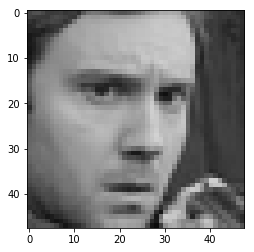

In [21]:
imshow(im)

In [23]:
from IPython.display import display,Image as jupI
display(jupI(pixels))

/usr/lib/python3/dist-packages/IPython/core/formatters.py:364: FormatterWarning: image/png formatter returned invalid type <class 'numpy.ndarray'> (expected (<class 'bytes'>, <class 'str'>)) for object: <IPython.core.display.Image object>
  FormatterWarning


<IPython.core.display.Image object>